### List datasets that will be used for training with scBasset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ~/workspace/theislab/mubind-pipeline/notebooks/pipeline

/mnt/c/Users/IgnacioIbarra/Dropbox/workspace/theislab/mubind-pipeline/notebooks/pipeline


/home/ilibarra/.conda/envs/mubind/lib/python3.9/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/ilibarra/.conda/envs/mubind/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
import mubind as mb
import utils

In [4]:
path_by_dataset = utils.get_datasets()
for k in path_by_dataset:
    print(k)
    if k != 'pancreatic_endocrinogenesis':
        continue

organoids
gbm
noack_2022
pancreatic_endocrinogenesis
pbmc


In [5]:
import torch
path_by_dataset = utils.get_datasets()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


move to relevant directory to execute scbasset

In [6]:
import scanpy as sc
# only focus on the peaks defined by scBasset during training/testing
import os
import h5py
import torch.optim as topti
import warnings
import torch.utils.data as tdata
import glob
import numpy as np

In [90]:
# prepare mubind's input based on what scBasset sees when calling its main trainer
def prepare_mubind_input(scbasset_ad_path,
                         adata,
                         k,
                         scbasset_split_file):
    species = 'hg38' if (k != 'noack_2022' and k != 'pancreatic_endocrinogenesis') else 'mm10'
    gen_path = '/mnt/c/Users/IgnacioIbarra/Dropbox/annotations/%s/genome/%s.fa' % (species, species)

    ad_scbasset = sc.read_h5ad(scbasset_ad_path)
    list(map(os.path.exists, [scbasset_split_file, scbasset_ad_path]))

    # csr matrices
    with h5py.File(scbasset_split_file, 'r') as hf:
        train_ids = hf['train_ids'][:]
        val_ids = hf['val_ids'][:]
        test_ids = hf['test_ids'][:]


    # print(adata.var)

    sep = '-' if k != 'gbm' else ':'
    adata.var['chr'] = np.where(adata.var_names.str.contains(':'),
                                adata.var_names.str.split(':').str[0],
                                adata.var_names.str.split('-').str[0])
    adata.var['chr'] = np.where(~adata.var['chr'].str.contains('chr'), 'chr', '') + adata.var['chr']

    colon_found = adata.var_names.str.contains(':').any()
    colon_found
    if colon_found:
        adata.var['start'] =   adata.var_names.str.split(':').str[1].str.split('-').str[0]
        adata.var['end'] = adata.var_names.str.split(':').str[1].str.split('-').str[1]
    else:
        adata.var['start'] = adata.var_names.str.split('-').str[1]
        adata.var['end'] = adata.var_names.str.split('-').str[2]
        
    # print(adata.var[['chr', 'start', 'end']])

    adata.var['seq_length'] = adata.var['end'].astype(int) - adata.var['start'].astype(int) + 1
    adata.var['k_summit'] = adata.var['chr'] + ':' + adata.var['start'] + '-' + adata.var['end']

    adata_train = adata[:,ad_scbasset.var_names[train_ids]].copy()
    adata_test = adata[:,ad_scbasset.var_names[test_ids]].copy()
    adata.shape, adata_train.shape, adata_test.shape


    n_seqs = None # None

    print('preparing sequences train...')
    seqs_train = mb.bindome.tl.get_sequences_from_bed(adata_train.var[['chr', 'start', 'end']].head(n_seqs),
                                                    gen_path=gen_path,
                                                    uppercase=True)
                                                # gen_path='../../../annotations/dm6/genome/dm6.fa')
    keys_train = set([s[0] for s in seqs_train])
    adata_train = adata_train[:,adata_train.var['k_summit'].isin(keys_train)]


    print('preparing sequences test...')
    seqs_test = mb.bindome.tl.get_sequences_from_bed(adata_test.var[['chr', 'start', 'end']].head(n_seqs),
                                                    gen_path=gen_path,
                                                    uppercase=True)
                                                # gen_path='../../../annotations/dm6/genome/dm6.fa')
    keys_test = set([s[0] for s in seqs_test])
    adata_test = adata_test[:,adata_test.var['k_summit'].isin(keys_test)]

    print(adata_train.shape, adata_test.shape)

    print('sum of reads', adata_train.X.sum())
    assert adata_train.X.sum() > 0

    df_train = utils.prepare_df(seqs_train, adata_train)
    df_test = utils.prepare_df(seqs_test, adata_test)

    df_train.shape, df_test.shape

    dataset_train = mb.datasets.SelexDataset(df_train,
                                            n_rounds=df_train.shape[1],
                                            enr_series=False)
    train = tdata.DataLoader(dataset=dataset_train,
                            batch_size=512,
                            shuffle=True)
    dataset_test = mb.datasets.SelexDataset(df_train,
                                            n_rounds=df_train.shape[1],
                                            enr_series=False)
    test = tdata.DataLoader(dataset=dataset_test,
                            batch_size=512,
                            shuffle=False)
    
    return adata_train, train, test


noack_2022 /mnt/f/workspace/theislab/mubind/data/noack_2022/random/merged_scATAC_integrated_cicero_faye_chong_obs1000_var3000.h5ad
reading anndata /mnt/f/workspace/theislab/mubind/data/noack_2022/random/merged_scATAC_integrated_cicero_faye_chong_obs1000_var3000.h5ad
noack_2022 (1000, 3000)
/mnt/f/workspace/theislab/mubind/data/noack_2022/random/scbasset_input/obs1000/ad.h5ad
True /mnt/f/workspace/theislab/mubind/data/noack_2022/random/mubind_output/obs1000/model_1.pt
preparing sequences train...
/tmp/tmpj89mv0wt
genome hg19 False
/mnt/c/Users/IgnacioIbarra/Dropbox/annotations/mm10/genome/mm10.fa
True /mnt/c/Users/IgnacioIbarra/Dropbox/annotations/mm10/genome/mm10.fa
running bedtools...
['bedtools', 'getfasta', '-fi', '/mnt/c/Users/IgnacioIbarra/Dropbox/annotations/mm10/genome/mm10.fa', '-bed', '/tmp/tmpj89mv0wt', '-fo', '/tmp/tmpsqeokmcu']
bedtools getfasta -fi /mnt/c/Users/IgnacioIbarra/Dropbox/annotations/mm10/genome/mm10.fa -bed /tmp/tmpj89mv0wt -fo /tmp/tmpsqeokmcu
preparing seque

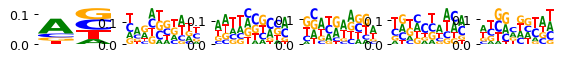

current kernels
\Filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 0 to (1, 0)
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
# epochs: 50 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.28it/s]


Current time: 2024-05-13 12:41:39.076752
	Loss: 4.5607631207 , R2: 0.19
	Training time (model/function): (5.444s / 5.444s)
		per epoch (model/function): (0.111s/ 0.111s)
		per 1k samples: 0.041s
optimization of dinuc is not necessary for the intercepts (filter=0). Skip...
current kernels
\Filter to optimize 1 

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 1 to (1, 0)
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
# epochs: 25 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.55it/s]


Current time: 2024-05-13 12:41:49.758622
	Loss: 4.2918597857 , R2: 0.19
	Training time (model/function): (15.273s / 9.829s)
		per epoch (model/function): (0.636s/ 0.410s)
		per 1k samples: 0.152s


final refinement step (after shift)...

unfreezing all layers for final refinement
optimizer:  Adam , criterion: PoissonLoss 
# epochs: 25 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  3.12it/s]


Current time: 2024-05-13 12:41:58.730149
	Loss: 4.1837822596 , R2: 0.19
	Training time (model/function): (23.338s / 8.065s)
		per epoch (model/function): (0.972s/ 0.336s)
		per 1k samples: 0.125s
best loss 4.183683633804321
current r2 values by newly added filter
[0.18913220793064056]
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernels
\Filter to optimize 2 

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 2 to (1, 0)
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
# epochs: 25 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.64it/s]


Current time: 2024-05-13 12:42:10.520964
	Loss: 4.1866811117 , R2: 0.19
	Training time (model/function): (32.846s / 9.508s)
		per epoch (model/function): (1.369s/ 0.396s)
		per 1k samples: 0.147s


final refinement step (after shift)...

unfreezing all layers for final refinement
optimizer:  Adam , criterion: PoissonLoss 
# epochs: 25 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.67it/s]


Current time: 2024-05-13 12:42:21.095931
	Loss: 4.1508512497 , R2: 0.19
	Training time (model/function): (42.270s / 9.424s)
		per epoch (model/function): (1.761s/ 0.393s)
		per 1k samples: 0.146s
best loss 4.148985703786214
current r2 values by newly added filter
[0.18913220793064056, 0.19037535590976118]
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernels
\Filter to optimize 3 

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 3 to (1, 0)
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
# epochs: 25 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.55it/s]


Current time: 2024-05-13 12:42:33.089541
	Loss: 4.1753902435 , R2: 0.19
	Training time (model/function): (52.120s / 9.850s)
		per epoch (model/function): (2.172s/ 0.410s)
		per 1k samples: 0.152s


final refinement step (after shift)...

unfreezing all layers for final refinement
optimizer:  Adam , criterion: PoissonLoss 
# epochs: 25 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.59it/s]


Current time: 2024-05-13 12:42:43.715355
	Loss: 4.1467661063 , R2: 0.19
	Training time (model/function): (61.833s / 9.712s)
		per epoch (model/function): (2.576s/ 0.405s)
		per 1k samples: 0.150s
best loss 4.142818133036296
current r2 values by newly added filter
[0.18913220793064056, 0.19037535590976118, 0.19091829807833594]
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernels
\Filter to optimize 4 

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 4 to (1, 0)
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
# epochs: 25 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  2.78it/s]


Current time: 2024-05-13 12:42:54.562885
	Loss: 4.1722535292 , R2: 0.19
	Training time (model/function): (70.861s / 9.028s)
		per epoch (model/function): (2.953s/ 0.376s)
		per 1k samples: 0.140s


final refinement step (after shift)...

unfreezing all layers for final refinement
optimizer:  Adam , criterion: PoissonLoss 
# epochs: 25 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:09<00:00,  2.71it/s]


Current time: 2024-05-13 12:43:04.789260
	Loss: 4.1477465630 , R2: 0.19
	Training time (model/function): (80.146s / 9.286s)
		per epoch (model/function): (3.339s/ 0.387s)
		per 1k samples: 0.144s
best loss 4.143146514892578
current r2 values by newly added filter
[0.18913220793064056, 0.19037535590976118, 0.19091829807833594, 0.19151259628905248]
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...

optimization finished:
total time: 80.14648222923279s
Time per epoch (total): 0.401 s
True /mnt/f/workspace/theislab/mubind/data/noack_2022/random/mubind_output/obs1000/running_time.pkl
noack_2022 /mnt/f/workspace/theislab/mubind/data/noack_2022/random/mubind_output/obs1000/model_1.pt

optimize log dynamics True
setting up log dynamic
True
12
order None
0 out of 7...


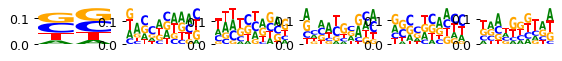

current kernels
\Filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 0 to (1, 0)
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
# epochs: 50 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [09:11<00:00, 11.02s/it]


Current time: 2024-05-13 12:52:40.286959
	Loss: 4.5589572589 , R2: 0.19
	Training time (model/function): (551.201s / 551.201s)
		per epoch (model/function): (11.249s/ 11.249s)
		per 1k samples: 4.174s
optimization of dinuc is not necessary for the intercepts (filter=0). Skip...
current kernels
\Filter to optimize 1 

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 1 to (1, 0)
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
# epochs: 25 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [07:15<00:00, 17.40s/it]


Current time: 2024-05-13 12:59:57.259012
	Loss: 4.2893736362 , R2: 0.19
	Training time (model/function): (986.298s / 435.097s)
		per epoch (model/function): (41.096s/ 18.129s)
		per 1k samples: 6.727s


final refinement step (after shift)...

unfreezing all layers for final refinement
optimizer:  Adam , criterion: PoissonLoss 
# epochs: 25 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [08:45<00:00, 21.01s/it]


Current time: 2024-05-13 13:08:43.673805
	Loss: 4.1893884341 , R2: 0.19
	Training time (model/function): (1511.612s / 525.314s)
		per epoch (model/function): (62.984s/ 21.888s)
		per 1k samples: 8.122s
best loss 4.186452388763428
current r2 values by newly added filter
[0.18912125365271193]
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernels
\Filter to optimize 2 

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 2 to (1, 0)
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
# epochs: 25 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [03:25<00:00,  8.20s/it]


Current time: 2024-05-13 13:12:11.438454
	Loss: 4.1810699304 , R2: 0.19
	Training time (model/function): (1716.791s / 205.179s)
		per epoch (model/function): (71.533s/ 8.549s)
		per 1k samples: 3.172s


final refinement step (after shift)...

unfreezing all layers for final refinement
optimizer:  Adam , criterion: PoissonLoss 
# epochs: 25 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [03:30<00:00,  8.44s/it]


Current time: 2024-05-13 13:15:43.619196
	Loss: 4.1487789949 , R2: 0.19
	Training time (model/function): (1927.769s / 210.978s)
		per epoch (model/function): (80.324s/ 8.791s)
		per 1k samples: 3.262s
best loss 4.148562749226888
current r2 values by newly added filter
[0.18912125365271193, 0.1891173473922334]
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernels
\Filter to optimize 3 

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 3 to (1, 0)
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
# epochs: 25 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [03:41<00:00,  8.85s/it]


Current time: 2024-05-13 13:19:26.831926
	Loss: 4.1700116793 , R2: 0.19
	Training time (model/function): (2148.987s / 221.217s)
		per epoch (model/function): (89.541s/ 9.217s)
		per 1k samples: 3.420s


final refinement step (after shift)...

unfreezing all layers for final refinement
optimizer:  Adam , criterion: PoissonLoss 
# epochs: 25 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [05:50<00:00, 14.02s/it]


Current time: 2024-05-13 13:25:18.691889
	Loss: 4.1494696935 , R2: 0.19
	Training time (model/function): (2499.511s / 350.524s)
		per epoch (model/function): (104.146s/ 14.605s)
		per 1k samples: 5.419s
best loss 4.144874731699626
current r2 values by newly added filter
[0.18912125365271193, 0.1891173473922334, 0.18906022617753349]
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernels
\Filter to optimize 4 

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 4 to (1, 0)
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
# epochs: 25 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [05:31<00:00, 13.25s/it]


Current time: 2024-05-13 13:30:52.823166
	Loss: 4.1652978261 , R2: 0.19
	Training time (model/function): (2830.834s / 331.323s)
		per epoch (model/function): (117.951s/ 13.805s)
		per 1k samples: 5.122s


final refinement step (after shift)...

unfreezing all layers for final refinement
optimizer:  Adam , criterion: PoissonLoss 
# epochs: 25 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [06:36<00:00, 15.87s/it]


Current time: 2024-05-13 13:37:37.834125
	Loss: 4.1456394990 , R2: 0.19
	Training time (model/function): (3227.659s / 396.825s)
		per epoch (model/function): (134.486s/ 16.534s)
		per 1k samples: 6.135s
best loss 4.145170291264852
current r2 values by newly added filter
[0.18912125365271193, 0.1891173473922334, 0.18906022617753349, 0.18911158920392424]
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...

optimization finished:
total time: 3227.6589615345s
Time per epoch (total): 16.138 s
True /mnt/f/workspace/theislab/mubind/data/noack_2022/random/mubind_output/obs1000/running_time.pkl

pancreatic_endocrinogenesis /mnt/f/workspace/theislab/mubind/data/pancreatic_endocrinogenesis/random/pancreas_multiome_2022_processed_atac_obs1000_var3000.h5ad
reading anndata /mnt/f/workspace/theislab/mubind/data/pancreatic_endocrinogenesis/random/pancreas_multiome_2022_processed_atac_obs1000_var3000.h5ad
pancreatic_endocrinogenesis (1000, 3000)
/mnt/f/workspace/theisl

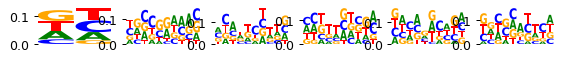

current kernels
\Filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 0 to (1, 0)
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
# epochs: 50 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:50<00:00,  3.41s/it]


Current time: 2024-05-13 13:41:13.348744
	Loss: 4.5330940088 , R2: 0.29
	Training time (model/function): (170.565s / 170.565s)
		per epoch (model/function): (3.481s/ 3.481s)
		per 1k samples: 1.289s
optimization of dinuc is not necessary for the intercepts (filter=0). Skip...
current kernels
\Filter to optimize 1 

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 1 to (1, 0)
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
# epochs: 25 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [02:13<00:00,  5.33s/it]


Current time: 2024-05-13 13:43:28.613810
	Loss: 4.2669040362 , R2: 0.29
	Training time (model/function): (303.954s / 133.389s)
		per epoch (model/function): (12.665s/ 5.558s)
		per 1k samples: 2.058s


final refinement step (after shift)...

unfreezing all layers for final refinement
optimizer:  Adam , criterion: PoissonLoss 
# epochs: 25 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:56<00:00,  2.27s/it]


Current time: 2024-05-13 13:44:27.300435
	Loss: 4.1603643894 , R2: 0.29
	Training time (model/function): (360.671s / 56.717s)
		per epoch (model/function): (15.028s/ 2.363s)
		per 1k samples: 0.875s
best loss 4.160364389419556
current r2 values by newly added filter
[0.2870981457402342]
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernels
\Filter to optimize 2 

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 2 to (1, 0)
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
# epochs: 25 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [01:04<00:00,  2.57s/it]


Current time: 2024-05-13 13:45:34.940932
	Loss: 4.1594498158 , R2: 0.29
	Training time (model/function): (424.932s / 64.261s)
		per epoch (model/function): (17.705s/ 2.678s)
		per 1k samples: 0.991s


final refinement step (after shift)...

unfreezing all layers for final refinement
optimizer:  Adam , criterion: PoissonLoss 
# epochs: 25 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [01:19<00:00,  3.19s/it]


Current time: 2024-05-13 13:46:57.280854
	Loss: 4.1285479069 , R2: 0.29
	Training time (model/function): (504.660s / 79.728s)
		per epoch (model/function): (21.027s/ 3.322s)
		per 1k samples: 1.230s
best loss 4.12415877978007
current r2 values by newly added filter
[0.2870981457402342, 0.2873158928148126]
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernels
\Filter to optimize 3 

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 3 to (1, 0)
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
# epochs: 25 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [01:38<00:00,  3.92s/it]


Current time: 2024-05-13 13:48:38.708834
	Loss: 4.1561324596 , R2: 0.29
	Training time (model/function): (602.822s / 98.162s)
		per epoch (model/function): (25.118s/ 4.090s)
		per 1k samples: 1.514s


final refinement step (after shift)...

unfreezing all layers for final refinement
optimizer:  Adam , criterion: PoissonLoss 
# epochs: 25 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [01:25<00:00,  3.44s/it]


Current time: 2024-05-13 13:50:06.568128
	Loss: 4.1211038431 , R2: 0.29
	Training time (model/function): (688.784s / 85.961s)
		per epoch (model/function): (28.699s/ 3.582s)
		per 1k samples: 1.326s
best loss 4.117915789286296
current r2 values by newly added filter
[0.2870981457402342, 0.2873158928148126, 0.28732063953111564]
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernels
\Filter to optimize 4 

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 4 to (1, 0)
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
# epochs: 25 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [02:36<00:00,  6.27s/it]


Current time: 2024-05-13 13:52:46.890469
	Loss: 4.1597972711 , R2: 0.29
	Training time (model/function): (845.625s / 156.842s)
		per epoch (model/function): (35.234s/ 6.535s)
		per 1k samples: 2.420s


final refinement step (after shift)...

unfreezing all layers for final refinement
optimizer:  Adam , criterion: PoissonLoss 
# epochs: 25 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [01:13<00:00,  2.92s/it]


Current time: 2024-05-13 13:54:01.886115
	Loss: 4.1211551030 , R2: 0.29
	Training time (model/function): (918.695s / 73.070s)
		per epoch (model/function): (38.279s/ 3.045s)
		per 1k samples: 1.127s
best loss 4.1190550327301025
current r2 values by newly added filter
[0.2870981457402342, 0.2873158928148126, 0.28732063953111564, 0.2872779633488447]
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...

optimization finished:
total time: 918.6954953670502s
Time per epoch (total): 4.593 s
True /mnt/f/workspace/theislab/mubind/data/pancreatic_endocrinogenesis/random/mubind_output/obs1000/running_time.pkl
pancreatic_endocrinogenesis /mnt/f/workspace/theislab/mubind/data/pancreatic_endocrinogenesis/random/mubind_output/obs1000/model_1.pt

optimize log dynamics True
setting up log dynamic
True
12
order None
0 out of 7...


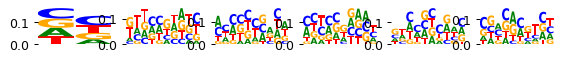

current kernels
\Filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 0 to (1, 0)
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
# epochs: 50 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [17:09<00:00, 20.58s/it]


Current time: 2024-05-13 14:11:36.467463
	Loss: 4.5306238333 , R2: 0.09
	Training time (model/function): (1029.120s / 1029.120s)
		per epoch (model/function): (21.002s/ 21.002s)
		per 1k samples: 7.776s
optimization of dinuc is not necessary for the intercepts (filter=0). Skip...
current kernels
\Filter to optimize 1 

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 1 to (1, 0)
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
# epochs: 25 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 13/25 [04:44<05:09, 25.82s/it]

In [91]:
res = []
import numpy as np
import pickle
n_epochs_intercept = 50
n_epochs_kernel = 25
overwrite = True
overwrite_train = True
log_each=75


for k in path_by_dataset:
    for ad_path in glob.glob(path_by_dataset[k]):
        if not '_obs1000_' in ad_path or not '/random/' in ad_path:
            continue

        n_cells = ad_path.split('_')[-2]
        print('')
        print(k, ad_path)

        # assert False
        print('reading anndata', ad_path)
        adata = sc.read_h5ad(ad_path)
        print(k, adata.shape)
        # if neighbors are not present in the file, we have to include them
        if not 'neighbors' in adata.uns:
            if 'int' in str(adata.X.dtype):
                adata.X = adata.X.astype(float)
            sc.pp.neighbors(adata, method='rapids')

        scbasset_split_file = os.path.join(os.path.dirname(ad_path), 'scbasset_input', n_cells, 'splits.h5')
        scbasset_ad_path = os.path.join(os.path.dirname(ad_path), 'scbasset_input', n_cells, 'ad.h5ad')

        print(scbasset_ad_path)

        if not os.path.exists(scbasset_ad_path):
            print('ad path not found. Next')
            continue

        mubind_outdir = os.path.join(os.path.dirname(ad_path), 'mubind_output', n_cells)
        if not os.path.exists(mubind_outdir):
            os.makedirs(mubind_outdir)
        
        model_path = os.path.join(mubind_outdir, 'model.pt')
        # print(os.path.exists(model_path), model_path)

        model_path_logdyn_true = model_path.replace('.pt', '_1.pt')
        print(os.path.exists(model_path_logdyn_true), model_path_logdyn_true)

        if not os.path.exists(model_path_logdyn_true) or overwrite:

            adata_train, train, test = prepare_mubind_input(scbasset_ad_path,
                                                            adata,
                                                            k,
                                                            scbasset_split_file)

            model_by_logdynamic = {}
            n_filters = 5
            opt_kernel_shift=[0, 0] + [0] * (n_filters)
            opt_kernel_length=[0, 0] + [0] * (n_filters)
            kernels=[0] + [2] + [20] * (n_filters)

            w = [10 for r in range(n_filters)]
            epochs = [n_epochs_intercept] + [n_epochs_kernel] * (n_filters + 1)
            print(epochs)
            skip_kernels=range(5, 500)
            opt_kernel_shift=[0, 0] + [0] * (n_filters)

            for optimize_log_dynamic in [False, True]: #  True]:

                # save model
                next_model_path = model_path.replace('.pt', '_%i.pt' % optimize_log_dynamic)
                print(k, next_model_path)
                if not os.path.exists(next_model_path) or overwrite_train:
                    print('')
                    print('optimize log dynamics', optimize_log_dynamic)
                    warnings.filterwarnings("ignore")

                    criterion = mb.tl.PoissonLoss()
                    # w = [r.shape[1] for r in pwms]
                    model = mb.models.Mubind.make_model(train,
                                                        n_filters,
                                                        criterion,
                                                        kernels=[0, 2] + w,
                                                        # use_dinuc=True, dinuc_mode='full',
                                                        optimize_sym_weight=False,
                                                        optimize_exp_barrier=True,
                                                        optimize_prob_act=True,
                                                        optimize_log_dynamic=optimize_log_dynamic,
                                                        use_dinuc=False,
                                                        device=device,
                                                        log_each=log_each,
                                                        p_dropout=None, # 0.8,
                                                        adata=adata_train if optimize_log_dynamic else None,
                                                        prepare_knn=optimize_log_dynamic,
                                                        dinuc_mode=None).cuda()

                    mb.pl.set_rcParams({'figure.figsize': [15, 3], 'figure.dpi': 90})
                    mb.pl.logo(model,
                            title=False,
                            xticks=False,
                            rowspan_dinuc=0,
                            rowspan_mono=1,
                            n_rows=5,
                            n_cols=12,
                            stop_at=10   ) # n_cols=len(reduced_groups))
                        
                    mb.pl.set_rcParams({'figure.figsize': [20, 5], 'figure.dpi': 100})

                    # mb.pl.conv(model, n_cols=2)
                    import torch.nn as tnn

                    if optimize_log_dynamic:
                        model.graph_module.conn_sparse = torch.tensor(adata[adata_train.obs_names,:].obsp['connectivities'].A).to_sparse().requires_grad_(True).cuda()
                        model.graph_module.log_dynamic = tnn.Parameter(torch.rand(model.graph_module.conn_sparse.indices().shape[1])) # .cuda()
                        model = model.cuda()
                        model.graph_module.log_dynamic.shape


                    import datetime
                    t1 = datetime.datetime.now()
                    model, best_loss = model.optimize_iterative(train,
                                                                n_epochs=epochs,
                                                                show_logo=False,
                                                                use_mono=True,
                                                                use_dinuc=False,
                                                                dinuc_mode='local',
                                                                opt_kernel_shift=opt_kernel_shift,
                                                                opt_kernel_length=opt_kernel_length,
                                                                opt_one_step=True,
                                                                shift_max=1,
                                                                shift_step=1,
                                                                optimiser=topti.Adam,
                                                                n_batches=1,
                                                                n_rounds=2,
                                                                num_epochs_shift_factor=1,
                                                                r2_per_epoch=True,
                                                                kernels=kernels,
                                                                skip_kernels=skip_kernels,
                                                                exp_max=8,
                                                                early_stopping=250,
                                                                log_each=log_each,
                                                                w=20,
                                                                max_w=20) #  target_dim=train.dataset.signal.shape[1])

                    t2 = datetime.datetime.now()

                    torch.save(model, next_model_path)
                    model_by_logdynamic[optimize_log_dynamic] = model

                    outpath_time = os.path.join(mubind_outdir, 'running_time.pkl')
                    time_diff = (t2 - t1)
                    pickle.dump(time_diff, open(outpath_time, 'wb'))
                    print(os.path.exists(outpath_time), outpath_time)
                    
                else:
                    model = torch.load(next_model_path)

                roc_auc_train, roc_auc_test = utils.get_auroc(model, train), utils.get_auroc(model, test)
                auprc_train, auprc_test = utils.get_auprc(model, train), utils.get_auprc(model, test)
                res.append([k, optimize_log_dynamic, 'train', 'roc_auc', roc_auc_train])
                res.append([k, optimize_log_dynamic, 'test', 'roc_auc', roc_auc_test])
                res.append([k, optimize_log_dynamic, 'train', 'roc_auc', auprc_train])
                res.append([k, optimize_log_dynamic, 'test', 'roc_auc', auprc_test])
            
            import pandas as pd
            df = pd.DataFrame(res, columns=['dataset', 'log_dynamic', 'group', 'metric', 'value'])
            df.to_csv(model_path.replace('.pt', '.csv'))